# Clasificador de imágenes de Charge Current Quasi Elastic interactions(CCQE: signal) vs backgrounds con CNN en SBND


En este proyecto se estudia el problema de clasificación binaria de imagenes (señal vs ruido)utilizando como datos de entrada simulaciones de eventos dentro del Short Baseline Neutrino Experiment (SBND). El objetivo es entrenar una CNN para separar imagenes de eventos donde se ha producido una interacción cargada cuasi-elástica (CCQE) del resto. Como imput se utiliza las imágenes producidas dentro de la Liquid Argon Time Projection Chamber (LArTPC) al leer la señal generada por los electrones en los wire planes de los laterales.

## Explorando los datos
Se descargan los datos en un fichero zip con 45 000 eventos con interacciones de neutrinos dentro del experimento SBND simulados dentro del framework de [LArSoft](https://larsoft.org/). Para la producción de los neutrinos se emplea el [generador MC Genie](https://github.com/GENIE-MC/Generator), mientras que la simulación de la propagación e interacción de los fotones y electrones dentro del argón se modela utilizando [GEANT 4](https://geant4.web.cern.ch/node/1). En la simulación se almacena la información Truth de la interacción que luego nos permite identificar las imágenes de cada evento como CCQE(señal) o background.


### Dependencias

In [1]:
# !pip install uproot #needed to read root files/trees
# !pip install awkward #needed for uproot to implement lazy arrays(memory isn't infine!)

import uproot
import awkward
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import collections
import scipy.ndimage


### Comentarios generales de los datos
Los datos se han repartido por comodidad en 11 archivos en formato .root, conteniendo cada uno 4200 eventos. Las imágenes se guardan como vectores de números decimales(floats). El módulo uproot provee la interfaz básica para leer los datos en formato .root y convertirlos a numpy arrays.

In [2]:
file_path="NNDumper_Data/NNDumper_tree_00.root"
file = uproot.open(file_path)
tree = file["nndumper"]["evttree;5"] 
print("Contenido del TTree:")
h=tree["TPCImgHeightU"].array().to_numpy()[0]
w=tree["TPCImgWidthU"].array().to_numpy()[0]
interaction=tree["InteractionType"].array().to_numpy()

branch = tree["TPCImgDataU"]
pics=branch.array().to_numpy().reshape(4200,h,w)#images are stored as vectors, switch them back to matrices again
pics/=np.max(pics) #normalize to 1.
NEvents=pics.shape[0]

# for i in range(pics.shape[0]):#uncomment these lines to smooth (gaussian filter) the data
#     pics[i]=scipy.ndimage.gaussian_filter(pics[i], sigma=2)

tree.show()

print("-----------")
print("Numero de eventos en el .root file: ",NEvents)
print("Tamaño de las imagenes de TPC:",w,"x",h)
print("-----------")
print("Primer evento: ")
print("Tipo de interaccion:",interaction[0],",1001=ChargeCurrentQuasiElastic (CCQE->Señal)") #1001 CCQE, lo demás, backgrounds (mirar interaction.png, cada numero es una interacción distinta)



Contenido del TTree:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
TPCImgDataU          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
TPCImgWidthU         | int32_t                  | AsDtype('>i4')
TPCImgHeightU        | int32_t                  | AsDtype('>i4')
TPCImgDataV          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
TPCImgWidthV         | int32_t                  | AsDtype('>i4')
TPCImgHeightV        | int32_t                  | AsDtype('>i4')
TPCImgDataY          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
TPCImgWidthY         | int32_t                  | AsDtype('>i4')
TPCImgHeightY        | int32_t                  | AsDtype('>i4')
OpImgData0           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
OpImgData1           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
OpImgWidth           |

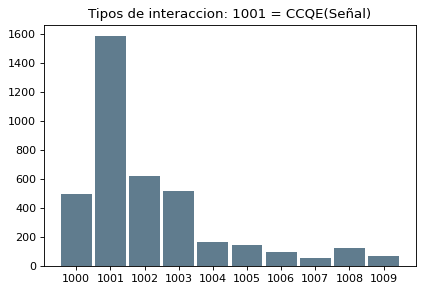

In [3]:
i_type=[];
picture_label=[]
for i in range(NEvents):
    i_type.append(interaction[i]);
    if(i_type[i]==1001):
      picture_label.append("signal")
    else:
      picture_label.append("background")

plt.figure(figsize=( 6,4), dpi=80);
plt.hist(i_type,10,[999.5,1009.5],color='#607c8e',rwidth=0.9)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title("Tipos de interaccion: 1001 = CCQE(Señal)")

# plt.figure(figsize=( 6,4), dpi=80);
# plt.title("Señal/ruido")
# plt.hist(picture_label,2,range=[-0.5,1.5],density=True,color='#607c8e',rwidth=0.9)
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#Renombramos señal con 1 y ruido con 0:
picture_label=[1 if x=="signal" else 0 for x in picture_label]


### Seleccionamos la señal

Raw:
(1584, 200, 248)
(2616, 200, 248)
50/50 %
(1000, 200, 248)
(1000, 200, 248)


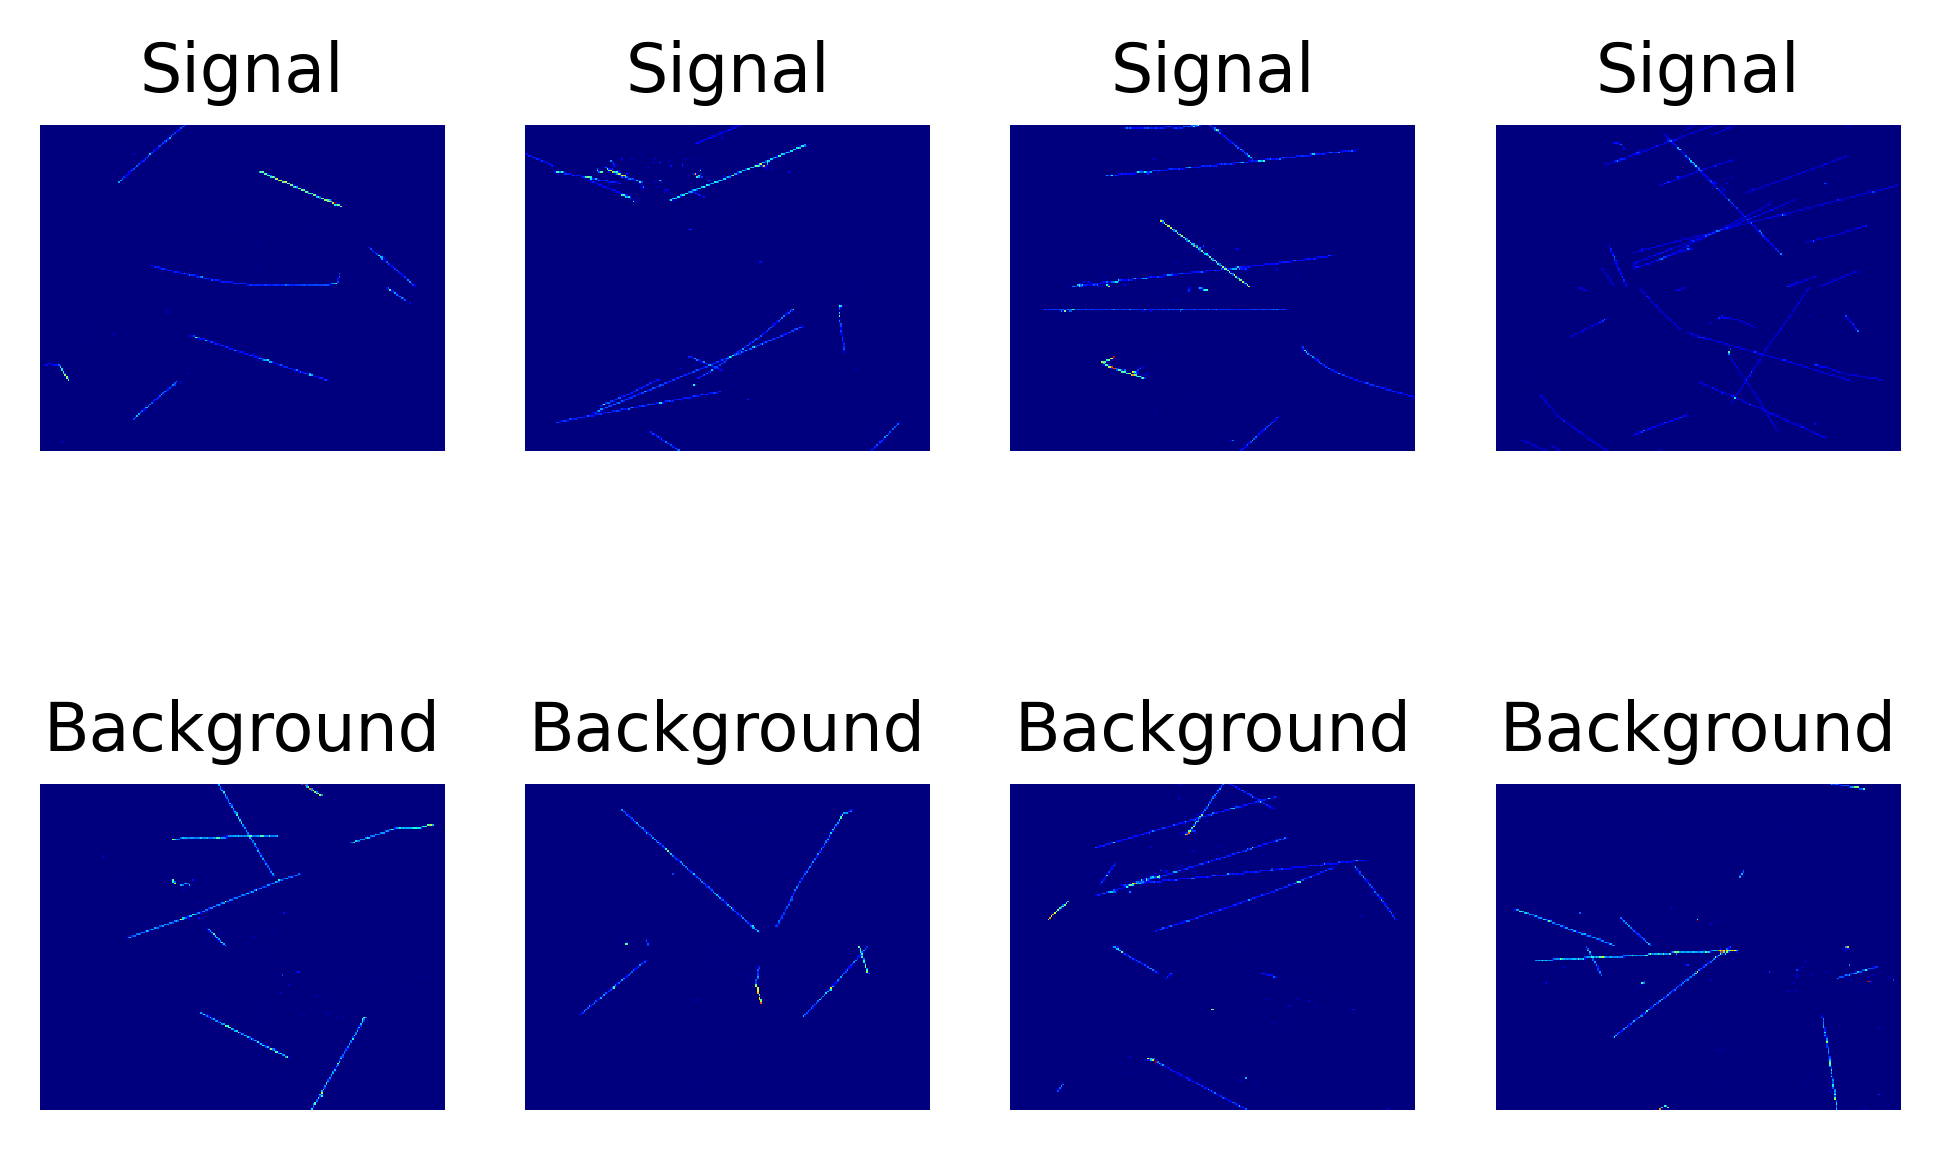

In [4]:
signal=1001

interaction_signal = interaction[interaction==signal]
interaction_bckg   = interaction[interaction!=signal]

pics_signal = pics[interaction==signal]
pics_bckg   = pics[interaction!=signal]

print("Raw:")
print(pics_signal.shape)
print(pics_bckg.shape)

print("50/50 %")
interaction_signal=pics_signal[:1000]
interaction_bckg=pics_bckg    [:1000]
pics_signal=pics_signal[:1000]
pics_bckg=pics_bckg    [:1000]

print(pics_signal.shape)
print(pics_bckg.shape)

plt.figure(figsize=( 6,4), dpi=400);
for i in range(4):
    sp = plt.subplot(2, 4, i+1)
    plt.title("Signal")
    sp.axis('Off') 
    plt.imshow(pics_signal[i],cmap = 'jet', interpolation='none');
    
    sp = plt.subplot(2, 4, i+5)
    sp.axis('Off') 
    plt.title("Background")
    plt.imshow(pics_bckg[i],cmap = 'jet', interpolation='none');



Separamos en 66% / 33% los eventos para entrenamiento y validación.

In [5]:
picture_label_validation=picture_label[:1400]
picture_label_train     =picture_label[1400:]
collections.Counter(picture_label)[1]
c_train     =collections.Counter(picture_label_train)
c_validation=collections.Counter(picture_label_validation)

print('total training signal images:', c_train[1])
print('total training background images:', c_train[0])
print('proporción señal/ruido: ', int(c_train[1]/(c_train[1]+c_train[0])*100),int(c_train[0]/(c_train[1]+c_train[0])*100))
print('\n')
print('total validation signal images:', collections.Counter(picture_label_validation)[1])
print('total validation background images:', collections.Counter(picture_label_validation)[0])
print('proporción señal/ruido: ', int(c_validation[1]/(c_validation[1]+c_validation[0])*100),int(c_validation[0]/(c_validation[1]+c_validation[0])*100))

total training signal images: 1094
total training background images: 1706
proporción señal/ruido:  39 60


total validation signal images: 490
total validation background images: 910
proporción señal/ruido:  35 65


### Smooth with gaussian filter approach

(4200, 200, 248)


Text(0.5, 1.0, 'Filtered')

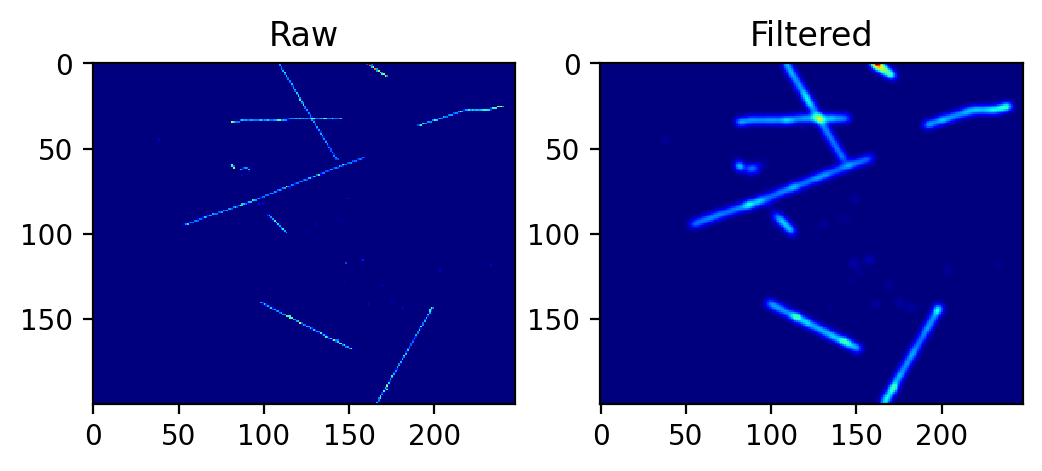

In [6]:

print(pics.shape)
plt.figure(figsize=( 6,4), dpi=200);

plt.imshow(pics[0],cmap = 'jet', interpolation='none');
filtered=scipy.ndimage.gaussian_filter(pics[0], sigma=2)
sp = plt.subplot(1, 2, 1)
plt.imshow(pics[0],cmap = 'jet', interpolation='none')
plt.title("Raw")
sp = plt.subplot(1, 2, 2)
plt.imshow(filtered,cmap = 'jet', interpolation='none')
plt.title("Filtered")

### Selection of data

In [7]:
pics3D=np.zeros((pics.shape[0],pics.shape[1],pics.shape[2],3))
print(pics3D.shape)
pics3D[:,:,:,0]=pics
pics3D[:,:,:,1]=pics
pics3D[:,:,:,2]=pics
#uncoment these to check copy is ok.
# plt.figure(figsize=( 6,4), dpi=200);
# plt.subplot(1, 4, 1)
# plt.imshow(pics[i],cmap = 'jet', interpolation='none');
# plt.subplot(1, 4, 2)
# plt.imshow(pics3D[i,:,:,0],cmap = 'jet', interpolation='none');
# plt.subplot(1, 4, 3)
# plt.imshow(pics3D[i,:,:,1],cmap = 'jet', interpolation='none');
# plt.subplot(1, 4, 4)
# plt.imshow(pics3D[i,:,:,2],cmap = 'jet', interpolation='none');

(4200, 200, 248, 3)


In [8]:
labels  = interaction
labels2 = labels==1001
labels3 = labels2.astype(int)
labels3

array([0, 1, 1, ..., 1, 0, 0])

In [9]:
labels3_validation=labels3[:1400]
labels3_train     =labels3[1400:]

pics_validation=pics[:1400,:,:]
pics_train     =pics[1400:,:,:]

pics3D_validation=pics3D[:1400,:,:,:]
pics3D_train     =pics3D[1400:,:,:,:]


## Definición de la CNN 

Las imágenes color se escalan a tamaño image_size X image_size píxeles, aunque en realidad son objetos 150x150x3 debido a los 3 colores RGB.

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import applications


### Dani model

In [21]:
# Capa de entrada de datos: image_size x image_size x 1
img_input = layers.Input(shape=(h, w, 1))

# Bloque convolucional formado por: 
# Capa convolucional con 16 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(6, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(12, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Se aplana el objeto de forma que en vez se tener un tensor 3D sea 1D.
x = layers.Flatten()(x)
# Capa de salida de una única neurona y función de activación sigmoide.
output = layers.Dense(1, activation='sigmoid')(x)

# Crear el modelo:
model = Model(img_input, output)

for x in model.layers:
  print(x.output_shape)


[(None, 200, 248, 1)]
(None, 198, 246, 6)
(None, 99, 123, 6)
(None, 97, 121, 12)
(None, 48, 60, 12)
(None, 34560)
(None, 1)


### Original Dogs Vs Cats

In [20]:
# Capa de entrada de datos: image_size x image_size x 3
img_input = layers.Input(shape=(h, w, 1))

# Bloque convolucional formado por: 
# Capa convolucional con 16 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Bloque convolucional formado por: 
# Capa convolucional con 32 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Bloque convolucional formado por: 
# Capa convolucional con 64 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Bloque convolucional formado por: 
# Capa convolucional con 64 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# En todos las capas anteriores se utiliza la función
# de activación relu.

# A continuación se añaden dos capas densas, 
# la primera de las cuales tiene una función de activación relu. 
# Finalmente la capa de salida tiene una sola neurona para producir 
# un único escalar con función de activación sigmoide para producir 
# una salida en el rango entre 0 y 1.

# Se aplana el objeto de forma que en vez se tener un tensor 3D sea 1D.
x = layers.Flatten()(x)

# Capa densa con función de activación relu.
x = layers.Dense(32, activation='relu')(x)

# Capa de salida de una única neurona y función de activación sigmoide.
output = layers.Dense(1, activation='sigmoid')(x)

# Crear el modelo:
model = Model(img_input, output)

for x in model.layers:
  print(x.output_shape)


[(None, 200, 248, 1)]
(None, 198, 246, 16)
(None, 99, 123, 16)
(None, 97, 121, 32)
(None, 48, 60, 32)
(None, 46, 58, 64)
(None, 23, 29, 64)
(None, 21, 27, 128)
(None, 10, 13, 128)
(None, 16640)
(None, 32)
(None, 1)


### Transfer learning - Deep model -> can not use onlly one layer (h,w,1), only 3 RGB pictures alowed (h,w,3)

In [17]:
# Se carga la parte convolucional del modelo entrenado VGG16.
# Very Deep Convolutional Networks for Large-Scale Image Recognition
# Karen Simonyan, Andrew Zisserman
# https://arxiv.org/abs/1409.1556

conv_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(h,w,3) )

# Se añaden una capa flatten,w
x = layers.Flatten()(conv_model.output)
# varias capas densas 
# (a medida que se añadan más capas densas el tiempo de entrenamiento se incrementa)
x = layers.Dense(10, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
# y una capa final softmax 
# predictions = layers.Dense(2, activation='softmax', name='dense_output')(x)
predictions = layers.Dense(1, activation='sigmoid',name='dense_output')(x)
# puesto que nuestro problema es un clasificador binario (gatos-perros)
# la capa de salida debe tener dos neuronas con softmax como función de activación.

# Crear el modelo completo
model = Model(inputs=conv_model.input, outputs=predictions)
model.summary()

# Bloquear el entrenamiento de todas las capas de la parte convolucional
for layer in conv_model.layers:
    layer.trainable = False
# Imprimir el número total de parámetros del modelo completo, 
# separando los entrenables de los no entrenables.
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights) 
non_trainable_count = count_params(model.non_trainable_weights) 
  
print('Parámetros totales: {:,}'.format(trainable_count + non_trainable_count)) 
print('Parámetros entrenables: {:,}'.format(trainable_count)) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 248, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 248, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 248, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 124, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 124, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 124, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 62, 128)       0   

### Compilar el modelo

In [18]:
# Entrenar el modelo.
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 248, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 248, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 248, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 124, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 124, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 124, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 62, 128)       0   

### Entrenamiento

In [19]:
print(pics3D_validation.shape)
print(pics3D_train.shape)
print(pics3D_train.shape)
print(labels3_train.shape)
print(labels3_validation.shape)

(1400, 200, 248, 3)
(2800, 200, 248, 3)
(2800, 200, 248, 3)
(2800,)
(1400,)


In [20]:
history=model.fit(pics3D_train[:100],labels3_train[:100], epochs=1, batch_size=1, validation_data=(pics3D_validation[:100],labels3_validation[:100]), verbose=1)

## Visualización de las representaciones intermedias

Se visualiza las características intermedias aprendidas por la CNN. Se puede observar como la entrada se transforma al pasar através de las capas. Se selecciona una imagen aleatoria del conjunto de entrenamiento y se visualiza durante su transformación. Cada fila corresponde con una capa y cada imagen en la fila con un filtro. 

In [23]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Se define un nuevo modelo que tendrá como entrada la imagen, 
# y como salida la representación intermedia de todas las capas. 
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

x = pics[48]  # Array Numpy array con dimensiones (1, image_size, image_size, 3)

# Reescalar por 1/255
x /= 255

# Se hace pasar la imagen através de la red. 
# Así se obtienen sus presentaciones intermedias. 
successive_feature_maps = visualization_model.predict(x)

# Se obtienen los nombres de las capas. 
layer_names = [layer.name for layer in model.layers]

# Dibjar representaciones
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Hacer con las capas convolucionales y max-pooling, pero no con las densas
    n_features = feature_map.shape[-1]  # número de características en un mapa
    # El mapa tiene dimensiones (1, size, size, n_features)
    size = feature_map.shape[1]
    # Título en las imágenes 
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Reprocesar para hacer visualizable 
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Horizontal display 
      display_grid[:, i * size : (i + 1) * size] = x
    # Mostrar 
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

ValueError: in user code:

    File "/home/rodrigoa/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/rodrigoa/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rodrigoa/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/rodrigoa/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/rodrigoa/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/rodrigoa/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 200, 248, 1), found shape=(None, 248)


## Evaluar la calidad del modelo

### Error y exactitud.
Se representan el error y la exactitud para los conjuntos de entrenamiento y validación.

In [ ]:
# Se recuperan el error y la exactitud de los conjuntos de 
# entrenamiento y validación 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de épocas
epochs = range(len(acc))

# Representación de la exactitud por época de los conjutos de 
# entrenamiento y validación plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Representación del error por época de los conjutos de 
# entrenamiento y validación 
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
Y_pred = model.predict(pics_validation)
Y_pred

Error: Session cannot generate requests

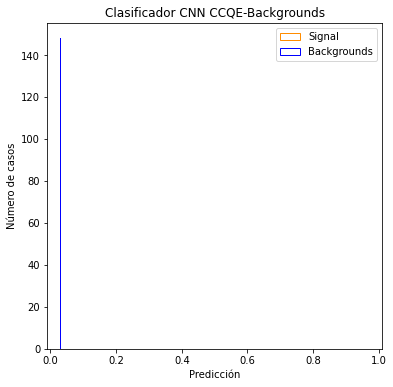

In [28]:
# Visualización de los pronósticos.
plt.figure(1,figsize=(6,6)) 
plt.style.use('seaborn-deep') 
plt.hist(Y_pred[labels3_validation==1],50,histtype='step',color='darkorange', label= "Signal")
plt.hist(Y_pred[labels3_validation==0],50,histtype='step',color='blue', label= "Backgrounds")
plt.ylabel('Número de casos')
plt.xlabel('Predicción')
plt.title("Clasificador CNN CCQE-Backgrounds")
plt.xlim(-0.01,1.01)
plt.legend( loc='upper right')
# plt.semilogx()
#from google.colab import files
#plt.savefig('ClasificadorCNNPerrosGatos.eps')
#files.download('ClasificadorCNNPerrosGatos.eps') # Descomentar para descargar localmente

### Matrix de confusión
La matrix de confusión es un sistema para evaluar la calidad de la predicción en resultados categóricos. 

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

Se generan las etiquetas de las imágenes del conjunto de validación. Primero los valores numéricos del pronósitico, el cual es separado en dos vectores iguales. La primera mitad corresponde a los gatos y la segunda mitad a los perros. Finalmente se transforma los valores numéricos en el rango de 0 a 1, en etiquetas 0 ó 1, en función si es menor o mayor de 0.5. Este umbral es completamente arbitrario.

In [30]:
Y_pred_signal     = Y_pred[labels3_validation==1]
Y_pred_background = Y_pred[labels3_validation==0]

In [31]:
Y_pred[Y_pred<=0.5] = 0
Y_pred[Y_pred>0.5] = 1

Se construye el vector que corresponde con las etiquetas originales del conjunto de validación

In [93]:
Y_label_ori= labels3_validation

In [94]:
cm=confusion_matrix(Y_label_ori, Y_pred)
print(cm)

[[1324    0]
 [  76    0]]


In [80]:
# Trues
TP = cm[1,1]; print(TP)
TN = cm[0,0]; print(TN)
# Falses
FP = cm[0,1]; print(FP)  
FN = cm[1,0]; print(FN)

0
1240
0
160


In [125]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity or true positive rate',TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('Specificity or true negative rate',TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('Precision or positive predictive value',np.round(PPV,3))
# Negative predictive value
NPV = TN/(TN+FN)
print('Negative predictive value',np.round(NPV,3))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False positive rate',FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate',FPR)
# False discovery rate
FDR = FP/(TP+FP)
print('False discovery rate',FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy',ACC)

Sensitivity or true positive rate 0.0625
Specificity or true negative rate 0.9508064516129032
Precision or positive predictive value 0.141
Negative predictive value 0.887
False positive rate 0.049193548387096775
False negative rate 0.049193548387096775
False discovery rate 0.8591549295774648
Accuracy 0.8492857142857143


## Propuestas adicionales.

*   Observar el sobreajuste producido si se sube el número de época, por ejemplo a 25. 
*   Modificar el número de filtros y bloques convolucionales para mejorar el rendimiento de la red. 
*   Si el tamaño de las imágenes se hace mucho más pequeño, cómo cambia el rendimiento del clasificador. ¿Y en la dirección contraria? 


